# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Ingrese su nombre y apellido

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


## Subir datasets de dígitos (train)

In [2]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt

--2023-10-29 01:24:06--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  --.-KB/s    in 0.006s  

2023-10-29 01:24:06 (96.6 MB/s) - ‘1_digits_train.txt’ saved [640604/640604]



In [3]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-29 01:24:06--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187595 (183K) [text/plain]
Saving to: ‘1_digits_test.txt’

1_digits_test.txt   100%[===================>] 183.20K  --.-KB/s    in 0.007s  

2023-10-29 01:24:06 (27.1 MB/s) - ‘1_digits_test.txt’ saved [187595/187595]



## Leer dataset de dígitos

In [4]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [5]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [6]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [7]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)


In [8]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)
print("Muestras de entrenamiento: ", len(df_train))
print("Muestras de validación: ", len(df_val))
print("Muestras de prueba: ", len(df_test))
print("Muestras totales: ", len(df_train_val)+len(df_test))

Muestras de entrenamiento:  3042
Muestras de validación:  1305
Muestras de prueba:  1272
Muestras totales:  5619


In [9]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-9-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-9-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-9-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

In [10]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


In [11]:
device = torch.device('cuda')
# Se establece una variable para cada futuro modelo neuronal con sus respectivas etiquetas de clases
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## Crear modelo

In [12]:
model_a = nn.Sequential(
          nn.Linear(64,10),
          nn.ReLU(),
          nn.Linear(10,10)      #entrada vs datos de salida, 10 vs 10
        )
model_a = model_a.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_a.parameters(), lr=1e-3)


# Definir parámetros de early stopping
patience = 10
best_val_loss = float('inf')
no_improvement_count = 0

In [13]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

In [14]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []
best_val_loss = float('inf')
best_epoch = 0
# Entrenamiento de la red por n epocas
for epoch in range(1000):                  #Se definen épocas = 1000

  # Guardar loss de cada batch para cada parte de los datos
  loss_train_batches = []
  loss_val_batches = []


  # Entrenamiento --------------------------------------------------------------
  model_a.train() #se define para que empiece el entrenamiento
  # Se establece un for para recorrer cada batch en cada época y parte del conjunto de datos.
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    optimizer.zero_grad() #descenso del gradiente
    outputs = model_a(inputs)           # Predicciones de entrenamiento que obtuvo el modelo, se calcula la pérdida
    loss = criterion(outputs, labels) # Loss o pérdida de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Se guarda la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item()) #sacar número específico a la pérdida de un 1 solo batch

  # se guarda el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_a.eval() #se le pasan los datos de validación para medir que tan bueno es
  #es similar al código superior, pero con datos de variación en vez de entrenamiento, sacando así predicción, probando la red, en vez de entrenar.
  with torch.no_grad():
    # Se itera dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_a(inputs)              # Obtenemos predicciones

      # Se guarda la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Se guarda el Loss de validación de la época actual y la época
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Se define early stopping en base al loss de entrenamiento y validación
  if loss_val[-1] < best_val_loss:
        best_val_loss = loss_val[-1]
        best_epoch = epoch
  elif epoch - best_epoch > patience:  # Detener si el loss de validación no mejora en relación de la variable patience
        break
end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

Epoch: 0, train loss: 2.2514, val loss: 2.1556
Epoch: 1, train loss: 2.0701, val loss: 1.9597
Epoch: 2, train loss: 1.8695, val loss: 1.7435
Epoch: 3, train loss: 1.6459, val loss: 1.5128
Epoch: 4, train loss: 1.4228, val loss: 1.3135
Epoch: 5, train loss: 1.2120, val loss: 1.1207
Epoch: 6, train loss: 1.0290, val loss: 0.9510
Epoch: 7, train loss: 0.8763, val loss: 0.7909
Epoch: 8, train loss: 0.7488, val loss: 0.6892
Epoch: 9, train loss: 0.6487, val loss: 0.6016
Epoch: 10, train loss: 0.5678, val loss: 0.5334
Epoch: 11, train loss: 0.5029, val loss: 0.4785
Epoch: 12, train loss: 0.4494, val loss: 0.4412
Epoch: 13, train loss: 0.4061, val loss: 0.3966
Epoch: 14, train loss: 0.3707, val loss: 0.3565
Epoch: 15, train loss: 0.3406, val loss: 0.3250
Epoch: 16, train loss: 0.3159, val loss: 0.3075
Epoch: 17, train loss: 0.2943, val loss: 0.2880
Epoch: 18, train loss: 0.2769, val loss: 0.2749
Epoch: 19, train loss: 0.2613, val loss: 0.2525
Epoch: 20, train loss: 0.2467, val loss: 0.2378
Ep

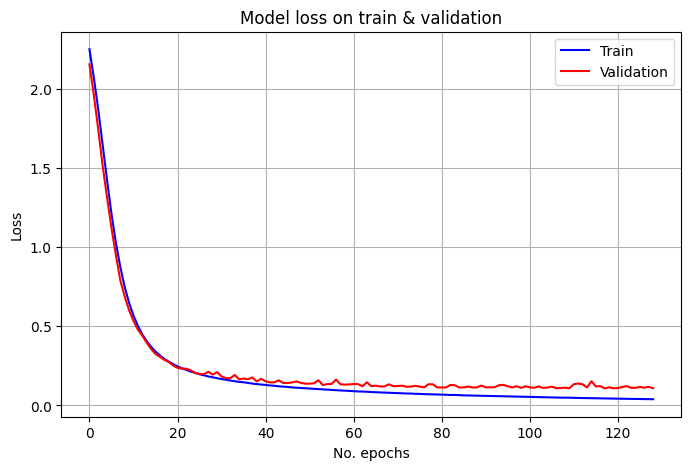

In [15]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

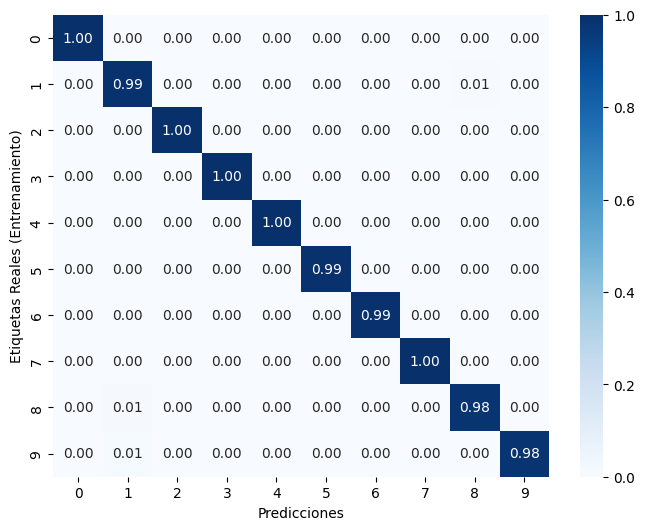

Accuracy Normalizado (Entrenamiento): 0.9934253780407627


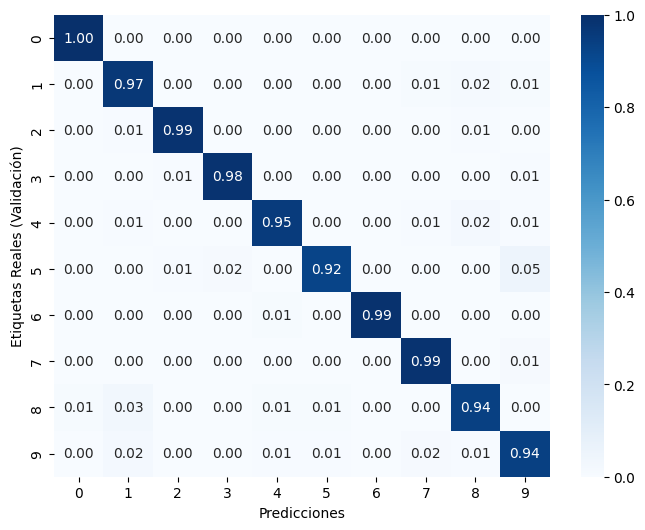

Accuracy Normalizado (Validación): 0.967816091954023


In [16]:
# Se guarda el modelo entrenado para el caso a
torch.save(model_a.state_dict(), 'model_a.pth')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score

# se calcula la matriz de confusión y el accuracy en el conjunto de entrenamiento
# Se crea la variable best_model para guardar el modelo en cuestión
best_model = model_a

# Se configura el modelo en modo de evaluación
best_model.eval()

# Se crean listas para almacenar predicciones y etiquetas reales
predictions_train = []
true_labels_train = []

# Se procede a evaluar el modelo en el conjunto de entrenamiento
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_train.extend(predicted.cpu().numpy())
        true_labels_train.extend(labels.cpu().numpy())

# Se calcula la matriz de confusión normalizada en el conjunto de entrenamiento, para luego crear un DataFrame de Pandas para la matriz de confusión en entrenamiento
confusion_matrix_train = confusion_matrix(true_labels_train, predictions_train, normalize='true')
confusion_df_train = pd.DataFrame(confusion_matrix_train, index=class_labels, columns=class_labels)

# Se configura el tamaño de la figura para entrenamiento
plt.figure(figsize=(8, 6))

# Se crea un heatmap de la matriz de confusión utilizando Seaborn para entrenamiento, para así visualizar la matriz de mejor manera
sns.heatmap(confusion_df_train, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Entrenamiento)")
plt.show()

# Se calcula el accuracy normalizado en entrenamiento
accuracy_normalized_train = accuracy_score(true_labels_train, predictions_train)
print("Accuracy Normalizado (Entrenamiento):", accuracy_normalized_train)

# para calcular con validación, se limpian las listas
predictions_train.clear()
true_labels_train.clear()

best_model.eval()

# Listas para almacenar predicciones y etiquetas reales en validación
predictions_val = []
true_labels_val = []

# Se evalúa el modelo en el conjunto de validación
with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_val.extend(predicted.cpu().numpy())
        true_labels_val.extend(labels.cpu().numpy())

# Aquí se define la matriz de confusión normalizada en el conjunto de validación y luego se crea un DataFrame de Pandas para la matriz de confusión en validación
confusion_matrix_val = confusion_matrix(true_labels_val, predictions_val, normalize='true')
confusion_df_val = pd.DataFrame(confusion_matrix_val, index=class_labels, columns=class_labels)

# se define el tamaño de la figura para validación
plt.figure(figsize=(8, 6))

# Se usa el comando seaborn heatmap para visualizar la matriz en cuestión
sns.heatmap(confusion_df_val, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Validación)")
plt.show()

# se calcula el accuracy normalizado en validación
accuracy_normalized_val = accuracy_score(true_labels_val, predictions_val)
print("Accuracy Normalizado (Validación):", accuracy_normalized_val)

## Crear datasets y dataloaders para pytorch (train)

In [17]:
model_b = nn.Sequential(
    nn.Linear(64, 40),  # 40 neuronas en la capa oculta
    nn.ReLU(),
    nn.Linear(40, 10)   # Capa de salida con 10 neuronas
)

model_b = model_b.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_b.parameters(), lr=1e-3)


# Definir parámetros de early stopping
patience = 10
best_val_loss = float('inf')
no_improvement_count = 0


## Crear datasets y dataloaders para pytorch (train)

In [18]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [19]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [20]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []
best_val_loss = float('inf')
best_epoch = 0
# Entrenamiento de la red por n epocas
for epoch in range(1000):                  #Se definen épocas = 1000

  # Guardar loss de cada batch para cada parte de los datos
  loss_train_batches = []
  loss_val_batches = []


  # Entrenamiento --------------------------------------------------------------
  model_b.train() #se define para que empiece el entrenamiento
  # Se establece un for para recorrer cada batch en cada época y parte del conjunto de datos.
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    optimizer.zero_grad() #descenso del gradiente
    outputs = model_b(inputs)           # Predicciones de entrenamiento que obtuvo el modelo, se calcula la pérdida
    loss = criterion(outputs, labels) # Loss o pérdida de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Se guarda la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item()) #sacar número específico a la pérdida de un 1 solo batch

  # se guarda el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_b.eval() #se le pasan los datos de validación para medir que tan bueno es
  #es similar al código superior, pero con datos de variación en vez de entrenamiento, sacando así predicción, probando la red, en vez de entrenar.
  with torch.no_grad():
    # Se itera dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_b(inputs)              # Obtenemos predicciones

      # Se guarda la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Se guarda el Loss de validación de la época actual y la época
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Se define early stopping en base al loss de entrenamiento y validación
  if loss_val[-1] < best_val_loss:
        best_val_loss = loss_val[-1]
        best_epoch = epoch
  elif epoch - best_epoch > patience:  # Detener si el loss de validación no mejora en relación de la variable patience
        break
end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

Epoch: 0, train loss: 2.1356, val loss: 1.9138
Epoch: 1, train loss: 1.7142, val loss: 1.4793
Epoch: 2, train loss: 1.2792, val loss: 1.0695
Epoch: 3, train loss: 0.9021, val loss: 0.7407
Epoch: 4, train loss: 0.6324, val loss: 0.5230
Epoch: 5, train loss: 0.4641, val loss: 0.4067
Epoch: 6, train loss: 0.3634, val loss: 0.3228
Epoch: 7, train loss: 0.2986, val loss: 0.2720
Epoch: 8, train loss: 0.2539, val loss: 0.2378
Epoch: 9, train loss: 0.2220, val loss: 0.2093
Epoch: 10, train loss: 0.1976, val loss: 0.2006
Epoch: 11, train loss: 0.1787, val loss: 0.1841
Epoch: 12, train loss: 0.1636, val loss: 0.1631
Epoch: 13, train loss: 0.1502, val loss: 0.1742
Epoch: 14, train loss: 0.1386, val loss: 0.1491
Epoch: 15, train loss: 0.1298, val loss: 0.1391
Epoch: 16, train loss: 0.1201, val loss: 0.1349
Epoch: 17, train loss: 0.1135, val loss: 0.1423
Epoch: 18, train loss: 0.1061, val loss: 0.1287
Epoch: 19, train loss: 0.0997, val loss: 0.1207
Epoch: 20, train loss: 0.0943, val loss: 0.1160
Ep

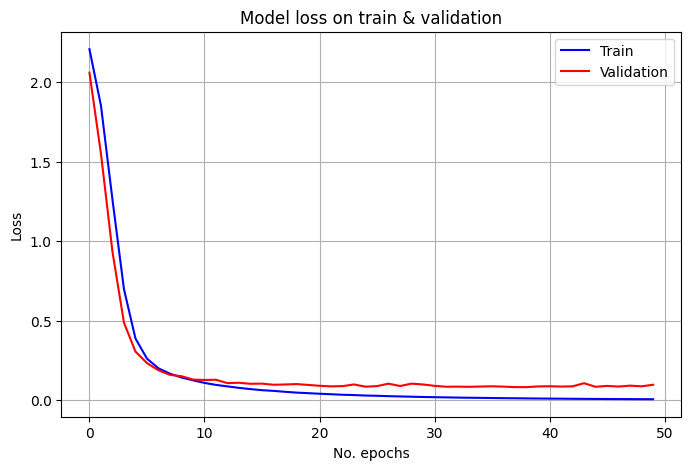

In [44]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

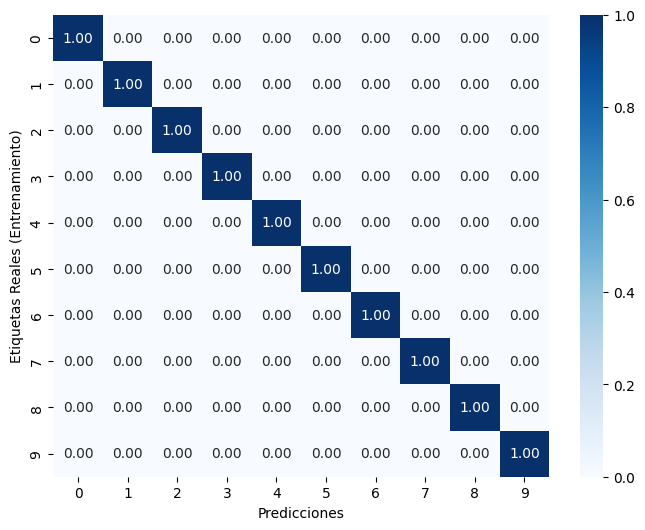

Accuracy Normalizado (Entrenamiento): 0.9996712689020382


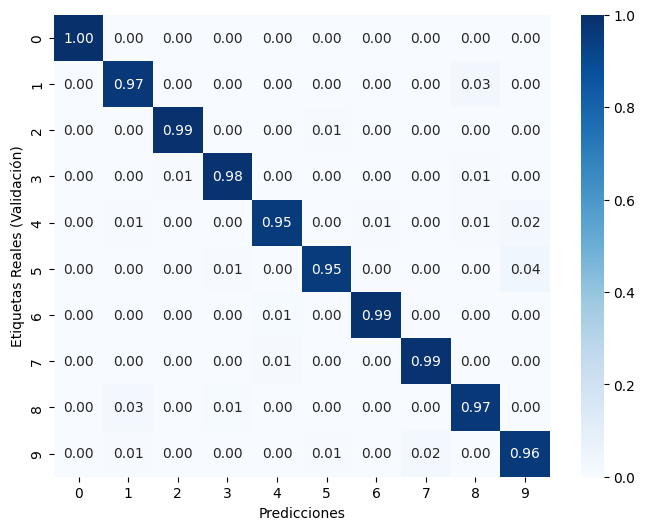

Accuracy Normalizado (Validación): 0.9762452107279693


In [22]:
# Guarda el modelo entrenado para el caso b
torch.save(model_b.state_dict(), 'model_b.pth')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score

# se calcula la matriz de confusión y el accuracy en el conjunto de entrenamiento
# Se crea la variable best_model para guardar el modelo en cuestión
best_model = model_b

# Se configura el modelo en modo de evaluación
best_model.eval()

# Se crean listas para almacenar predicciones y etiquetas reales
predictions_train = []
true_labels_train = []

# Se procede a evaluar el modelo en el conjunto de entrenamiento
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_train.extend(predicted.cpu().numpy())
        true_labels_train.extend(labels.cpu().numpy())

# Se calcula la matriz de confusión normalizada en el conjunto de entrenamiento, para luego crear un DataFrame de Pandas para la matriz de confusión en entrenamiento
confusion_matrix_train = confusion_matrix(true_labels_train, predictions_train, normalize='true')
confusion_df_train = pd.DataFrame(confusion_matrix_train, index=class_labels, columns=class_labels)

# Se configura el tamaño de la figura para entrenamiento
plt.figure(figsize=(8, 6))

# Se crea un heatmap de la matriz de confusión utilizando Seaborn para entrenamiento, para así visualizar la matriz de mejor manera
sns.heatmap(confusion_df_train, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Entrenamiento)")
plt.show()

# Se calcula el accuracy normalizado en entrenamiento
accuracy_normalized_train = accuracy_score(true_labels_train, predictions_train)
print("Accuracy Normalizado (Entrenamiento):", accuracy_normalized_train)

# para calcular con validación, se limpian las listas
predictions_train.clear()
true_labels_train.clear()

best_model.eval()

# Listas para almacenar predicciones y etiquetas reales en validación
predictions_val = []
true_labels_val = []

# Se evalúa el modelo en el conjunto de validación
with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_val.extend(predicted.cpu().numpy())
        true_labels_val.extend(labels.cpu().numpy())

# Aquí se define la matriz de confusión normalizada en el conjunto de validación y luego se crea un DataFrame de Pandas para la matriz de confusión en validación
confusion_matrix_val = confusion_matrix(true_labels_val, predictions_val, normalize='true')
confusion_df_val = pd.DataFrame(confusion_matrix_val, index=class_labels, columns=class_labels)

# se define el tamaño de la figura para validación
plt.figure(figsize=(8, 6))

# Se usa el comando seaborn heatmap para visualizar la matriz en cuestión
sns.heatmap(confusion_df_val, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Validación)")
plt.show()

# se calcula el accuracy normalizado en validación
accuracy_normalized_val = accuracy_score(true_labels_val, predictions_val)
print("Accuracy Normalizado (Validación):", accuracy_normalized_val)

In [23]:
# Configuración de la red para el caso 2c
model_c = nn.Sequential(
    nn.Linear(64, 10),   # 10 neuronas en la capa oculta
    nn.Tanh(),
    nn.Linear(10, 10)    # Capa de salida con 10 neuronas
)

model_c = model_c.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_c.parameters(), lr=1e-3)

# Definir parámetros de early stopping
patience = 10
best_val_loss = float('inf')
no_improvement_count = 0

In [24]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

In [25]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []
best_val_loss = float('inf')
best_epoch = 0
# Entrenamiento de la red por n epocas
for epoch in range(1000):                  #Se definen épocas = 1000

  # Guardar loss de cada batch para cada parte de los datos
  loss_train_batches = []
  loss_val_batches = []


  # Entrenamiento --------------------------------------------------------------
  model_c.train() #se define para que empiece el entrenamiento
  # Se establece un for para recorrer cada batch en cada época y parte del conjunto de datos.
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    optimizer.zero_grad() #descenso del gradiente
    outputs = model_c(inputs)           # Predicciones de entrenamiento que obtuvo el modelo, se calcula la pérdida
    loss = criterion(outputs, labels) # Loss o pérdida de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Se guarda la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item()) #sacar número específico a la pérdida de un 1 solo batch

  # se guarda el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_c.eval() #se le pasan los datos de validación para medir que tan bueno es
  #es similar al código superior, pero con datos de variación en vez de entrenamiento, sacando así predicción, probando la red, en vez de entrenar.
  with torch.no_grad():
    # Se itera dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_c(inputs)              # Obtenemos predicciones

      # Se guarda la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Se guarda el Loss de validación de la época actual y la época
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Se define early stopping en base al loss de entrenamiento y validación
  if loss_val[-1] < best_val_loss:
        best_val_loss = loss_val[-1]
        best_epoch = epoch
  elif epoch - best_epoch > patience:  # Detener si el loss de validación no mejora en relación de la variable patience
        break
end = time.time()
print('Finished Training, total time %f seconds' % (end - start))


Epoch: 0, train loss: 2.2852, val loss: 2.1483
Epoch: 1, train loss: 2.0190, val loss: 1.9091
Epoch: 2, train loss: 1.8010, val loss: 1.7165
Epoch: 3, train loss: 1.6198, val loss: 1.5500
Epoch: 4, train loss: 1.4625, val loss: 1.4092
Epoch: 5, train loss: 1.3267, val loss: 1.2675
Epoch: 6, train loss: 1.2044, val loss: 1.1597
Epoch: 7, train loss: 1.0960, val loss: 1.0531
Epoch: 8, train loss: 1.0008, val loss: 0.9743
Epoch: 9, train loss: 0.9143, val loss: 0.8879
Epoch: 10, train loss: 0.8400, val loss: 0.8226
Epoch: 11, train loss: 0.7749, val loss: 0.7525
Epoch: 12, train loss: 0.7167, val loss: 0.6980
Epoch: 13, train loss: 0.6670, val loss: 0.6550
Epoch: 14, train loss: 0.6211, val loss: 0.6197
Epoch: 15, train loss: 0.5816, val loss: 0.5828
Epoch: 16, train loss: 0.5467, val loss: 0.5434
Epoch: 17, train loss: 0.5154, val loss: 0.5033
Epoch: 18, train loss: 0.4863, val loss: 0.4896
Epoch: 19, train loss: 0.4619, val loss: 0.4591
Epoch: 20, train loss: 0.4383, val loss: 0.4408
Ep

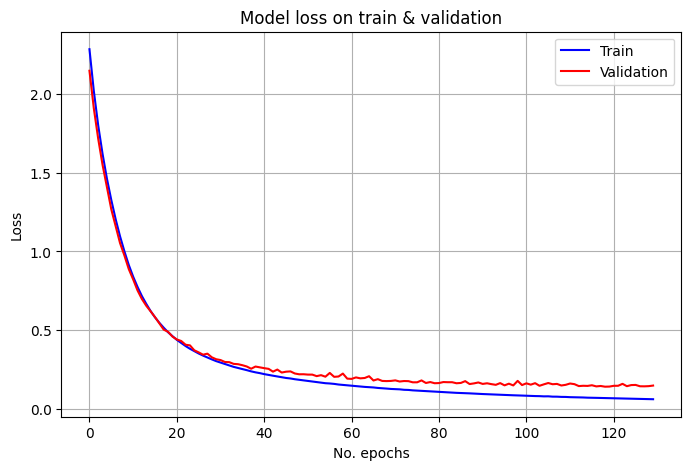

In [26]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

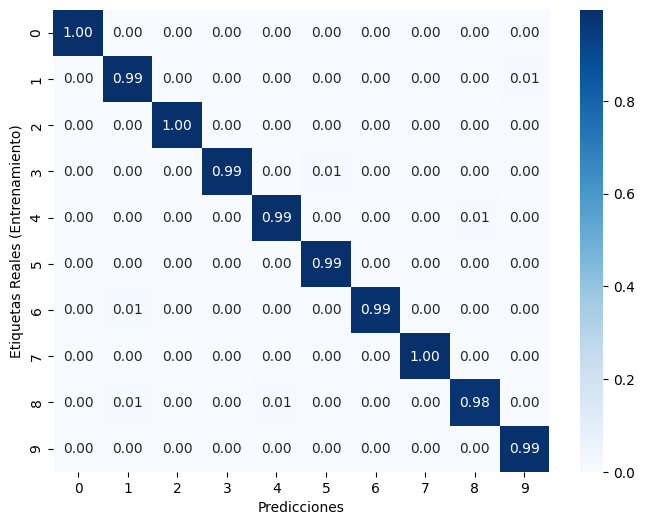

Accuracy Normalizado (Entrenamiento): 0.9917817225509533


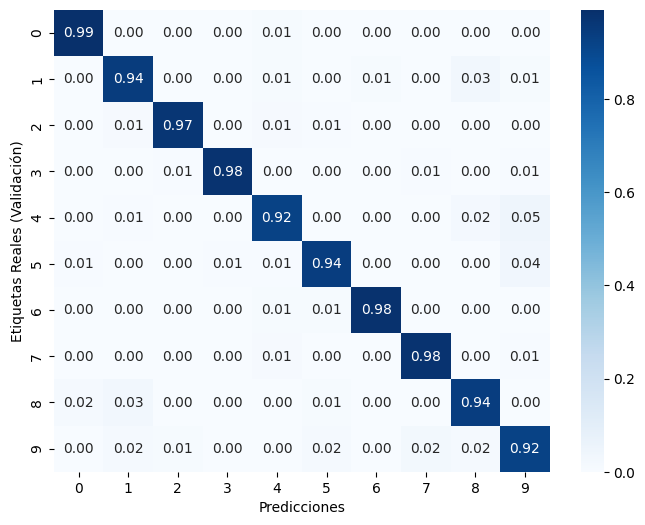

Accuracy Normalizado (Validación): 0.957088122605364


In [27]:
# Guarda el modelo entrenado para el caso c
torch.save(model_c.state_dict(), 'model_c.pth')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score

# se calcula la matriz de confusión y el accuracy en el conjunto de entrenamiento
# Se crea la variable best_model para guardar el modelo en cuestión
best_model = model_c

# Se configura el modelo en modo de evaluación
best_model.eval()

# Se crean listas para almacenar predicciones y etiquetas reales
predictions_train = []
true_labels_train = []

# Se procede a evaluar el modelo en el conjunto de entrenamiento
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_train.extend(predicted.cpu().numpy())
        true_labels_train.extend(labels.cpu().numpy())

# Se calcula la matriz de confusión normalizada en el conjunto de entrenamiento, para luego crear un DataFrame de Pandas para la matriz de confusión en entrenamiento
confusion_matrix_train = confusion_matrix(true_labels_train, predictions_train, normalize='true')
confusion_df_train = pd.DataFrame(confusion_matrix_train, index=class_labels, columns=class_labels)

# Se configura el tamaño de la figura para entrenamiento
plt.figure(figsize=(8, 6))

# Se crea un heatmap de la matriz de confusión utilizando Seaborn para entrenamiento, para así visualizar la matriz de mejor manera
sns.heatmap(confusion_df_train, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Entrenamiento)")
plt.show()

# Se calcula el accuracy normalizado en entrenamiento
accuracy_normalized_train = accuracy_score(true_labels_train, predictions_train)
print("Accuracy Normalizado (Entrenamiento):", accuracy_normalized_train)

# para calcular con validación, se limpian las listas
predictions_train.clear()
true_labels_train.clear()

best_model.eval()

# Listas para almacenar predicciones y etiquetas reales en validación
predictions_val = []
true_labels_val = []

# Se evalúa el modelo en el conjunto de validación
with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_val.extend(predicted.cpu().numpy())
        true_labels_val.extend(labels.cpu().numpy())

# Aquí se define la matriz de confusión normalizada en el conjunto de validación y luego se crea un DataFrame de Pandas para la matriz de confusión en validación
confusion_matrix_val = confusion_matrix(true_labels_val, predictions_val, normalize='true')
confusion_df_val = pd.DataFrame(confusion_matrix_val, index=class_labels, columns=class_labels)

# se define el tamaño de la figura para validación
plt.figure(figsize=(8, 6))

# Se usa el comando seaborn heatmap para visualizar la matriz en cuestión
sns.heatmap(confusion_df_val, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Validación)")
plt.show()

# se calcula el accuracy normalizado en validación
accuracy_normalized_val = accuracy_score(true_labels_val, predictions_val)
print("Accuracy Normalizado (Validación):", accuracy_normalized_val)

In [28]:
# Configuración de la red para el caso "d"
model_d = nn.Sequential(
    nn.Linear(64, 40),  # 40 neuronas en la capa oculta
    nn.Tanh(),
    nn.Linear(40, 10)   # Capa de salida con 10 neuronas
)

model_d = model_d.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_d.parameters(), lr=1e-3)

# Definir parámetros de early stopping
patience = 10
best_val_loss = float('inf')
no_improvement_count = 0

In [29]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

In [30]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []
best_val_loss = float('inf')
best_epoch = 0
# Entrenamiento de la red por n epocas
for epoch in range(1000):                  #Se definen épocas = 1000

  # Guardar loss de cada batch para cada parte de los datos
  loss_train_batches = []
  loss_val_batches = []


  # Entrenamiento --------------------------------------------------------------
  model_d.train() #se define para que empiece el entrenamiento
  # Se establece un for para recorrer cada batch en cada época y parte del conjunto de datos.
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    optimizer.zero_grad() #descenso del gradiente
    outputs = model_d(inputs)           # Predicciones de entrenamiento que obtuvo el modelo, se calcula la pérdida
    loss = criterion(outputs, labels) # Loss o pérdida de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Se guarda la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item()) #sacar número específico a la pérdida de un 1 solo batch

  # se guarda el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_d.eval() #se le pasan los datos de validación para medir que tan bueno es
  #es similar al código superior, pero con datos de variación en vez de entrenamiento, sacando así predicción, probando la red, en vez de entrenar.
  with torch.no_grad():
    # Se itera dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_d(inputs)              # Obtenemos predicciones

      # Se guarda la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Se guarda el Loss de validación de la época actual y la época
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Se define early stopping en base al loss de entrenamiento y validación
  if loss_val[-1] < best_val_loss:
        best_val_loss = loss_val[-1]
        best_epoch = epoch
  elif epoch - best_epoch > patience:  # Detener si el loss de validación no mejora en relación de la variable patience
        break
end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

Epoch: 0, train loss: 2.0347, val loss: 1.7454
Epoch: 1, train loss: 1.5161, val loss: 1.2914
Epoch: 2, train loss: 1.1230, val loss: 0.9625
Epoch: 3, train loss: 0.8367, val loss: 0.7292
Epoch: 4, train loss: 0.6361, val loss: 0.5502
Epoch: 5, train loss: 0.4993, val loss: 0.4459
Epoch: 6, train loss: 0.4063, val loss: 0.3825
Epoch: 7, train loss: 0.3425, val loss: 0.3121
Epoch: 8, train loss: 0.2954, val loss: 0.2846
Epoch: 9, train loss: 0.2598, val loss: 0.2549
Epoch: 10, train loss: 0.2336, val loss: 0.2318
Epoch: 11, train loss: 0.2117, val loss: 0.2184
Epoch: 12, train loss: 0.1948, val loss: 0.2072
Epoch: 13, train loss: 0.1797, val loss: 0.1874
Epoch: 14, train loss: 0.1666, val loss: 0.1681
Epoch: 15, train loss: 0.1557, val loss: 0.1603
Epoch: 16, train loss: 0.1460, val loss: 0.1696
Epoch: 17, train loss: 0.1379, val loss: 0.1515
Epoch: 18, train loss: 0.1307, val loss: 0.1480
Epoch: 19, train loss: 0.1234, val loss: 0.1691
Epoch: 20, train loss: 0.1175, val loss: 0.1484
Ep

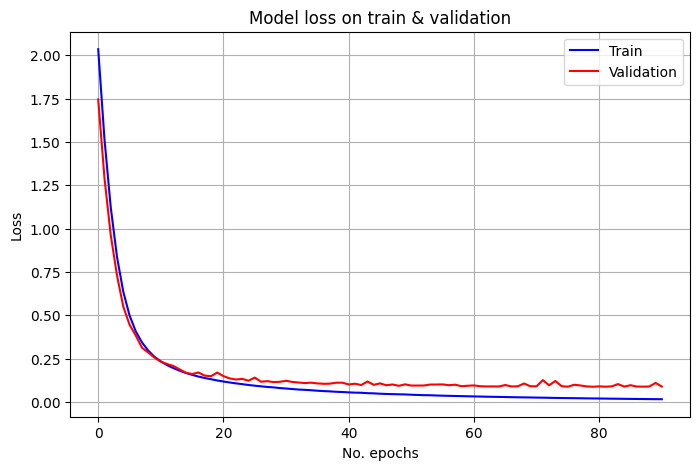

In [31]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

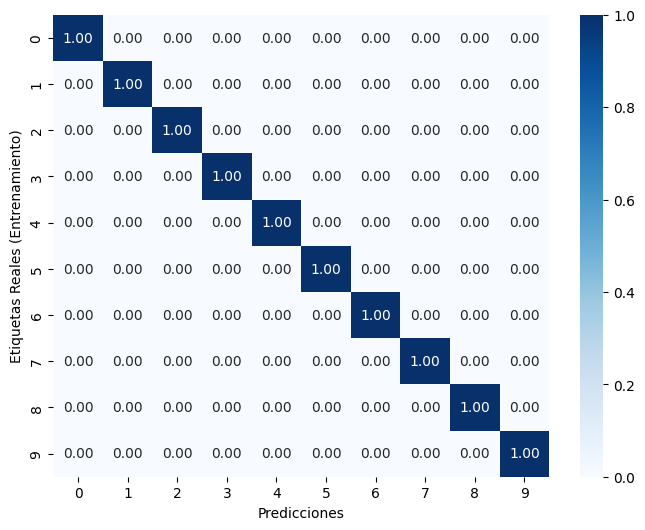

Accuracy Normalizado (Entrenamiento): 0.9996712689020382


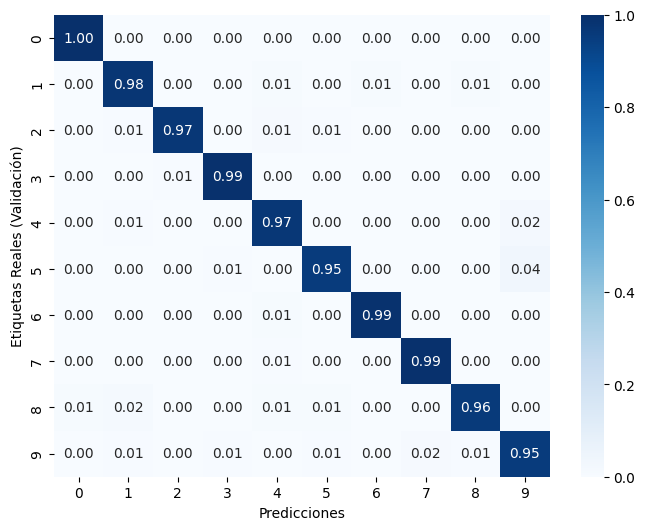

Accuracy Normalizado (Validación): 0.9762452107279693


In [32]:
# Guarda el modelo entrenado para el caso d
torch.save(model_d.state_dict(), 'model_d.pth')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score

# se calcula la matriz de confusión y el accuracy en el conjunto de entrenamiento
# Se crea la variable best_model para guardar el modelo en cuestión
best_model = model_d

# Se configura el modelo en modo de evaluación
best_model.eval()

# Se crean listas para almacenar predicciones y etiquetas reales
predictions_train = []
true_labels_train = []

# Se procede a evaluar el modelo en el conjunto de entrenamiento
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_train.extend(predicted.cpu().numpy())
        true_labels_train.extend(labels.cpu().numpy())

# Se calcula la matriz de confusión normalizada en el conjunto de entrenamiento, para luego crear un DataFrame de Pandas para la matriz de confusión en entrenamiento
confusion_matrix_train = confusion_matrix(true_labels_train, predictions_train, normalize='true')
confusion_df_train = pd.DataFrame(confusion_matrix_train, index=class_labels, columns=class_labels)

# Se configura el tamaño de la figura para entrenamiento
plt.figure(figsize=(8, 6))

# Se crea un heatmap de la matriz de confusión utilizando Seaborn para entrenamiento, para así visualizar la matriz de mejor manera
sns.heatmap(confusion_df_train, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Entrenamiento)")
plt.show()

# Se calcula el accuracy normalizado en entrenamiento
accuracy_normalized_train = accuracy_score(true_labels_train, predictions_train)
print("Accuracy Normalizado (Entrenamiento):", accuracy_normalized_train)

# para calcular con validación, se limpian las listas
predictions_train.clear()
true_labels_train.clear()

best_model.eval()

# Listas para almacenar predicciones y etiquetas reales en validación
predictions_val = []
true_labels_val = []

# Se evalúa el modelo en el conjunto de validación
with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_val.extend(predicted.cpu().numpy())
        true_labels_val.extend(labels.cpu().numpy())

# Aquí se define la matriz de confusión normalizada en el conjunto de validación y luego se crea un DataFrame de Pandas para la matriz de confusión en validación
confusion_matrix_val = confusion_matrix(true_labels_val, predictions_val, normalize='true')
confusion_df_val = pd.DataFrame(confusion_matrix_val, index=class_labels, columns=class_labels)

# se define el tamaño de la figura para validación
plt.figure(figsize=(8, 6))

# Se usa el comando seaborn heatmap para visualizar la matriz en cuestión
sns.heatmap(confusion_df_val, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Validación)")
plt.show()

# se calcula el accuracy normalizado en validación
accuracy_normalized_val = accuracy_score(true_labels_val, predictions_val)
print("Accuracy Normalizado (Validación):", accuracy_normalized_val)

In [33]:
# Configuración de la red para el caso "e"
model_e = nn.Sequential(
    nn.Linear(64, 10),  # 10 neuronas en la primera capa oculta
    nn.ReLU(),
    nn.Linear(10, 10),  # 10 neuronas en la segunda capa oculta
    nn.ReLU(),
    nn.Linear(10, 10)   # Capa de salida con 10 neuronas
)

model_e = model_e.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_e.parameters(), lr=1e-3)

# Definir parámetros de early stopping
patience = 10
best_val_loss = float('inf')
no_improvement_count = 0

In [34]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)


In [35]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []
best_val_loss = float('inf')
best_epoch = 0
# Entrenamiento de la red por n epocas
for epoch in range(1000):                  #Se definen épocas = 1000

  # Guardar loss de cada batch para cada parte de los datos
  loss_train_batches = []
  loss_val_batches = []


  # Entrenamiento --------------------------------------------------------------
  model_e.train() #se define para que empiece el entrenamiento
  # Se establece un for para recorrer cada batch en cada época y parte del conjunto de datos.
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    optimizer.zero_grad() #descenso del gradiente
    outputs = model_e(inputs)           # Predicciones de entrenamiento que obtuvo el modelo, se calcula la pérdida
    loss = criterion(outputs, labels) # Loss o pérdida de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Se guarda la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item()) #sacar número específico a la pérdida de un 1 solo batch

  # se guarda el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_e.eval() #se le pasan los datos de validación para medir que tan bueno es
  #es similar al código superior, pero con datos de variación en vez de entrenamiento, sacando así predicción, probando la red, en vez de entrenar.
  with torch.no_grad():
    # Se itera dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_e(inputs)              # Obtenemos predicciones

      # Se guarda la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Se guarda el Loss de validación de la época actual y la época
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Se define early stopping en base al loss de entrenamiento y validación
  if loss_val[-1] < best_val_loss:
        best_val_loss = loss_val[-1]
        best_epoch = epoch
  elif epoch - best_epoch > patience:  # Detener si el loss de validación no mejora en relación de la variable patience
        break
end = time.time()
print('Finished Training, total time %f seconds' % (end - start))


Epoch: 0, train loss: 2.2858, val loss: 2.2502
Epoch: 1, train loss: 2.1968, val loss: 2.1383
Epoch: 2, train loss: 2.0485, val loss: 1.9638
Epoch: 3, train loss: 1.8384, val loss: 1.7311
Epoch: 4, train loss: 1.6007, val loss: 1.4915
Epoch: 5, train loss: 1.3668, val loss: 1.2684
Epoch: 6, train loss: 1.1651, val loss: 1.0778
Epoch: 7, train loss: 0.9934, val loss: 0.9207
Epoch: 8, train loss: 0.8512, val loss: 0.7852
Epoch: 9, train loss: 0.7270, val loss: 0.6674
Epoch: 10, train loss: 0.6219, val loss: 0.5730
Epoch: 11, train loss: 0.5353, val loss: 0.4909
Epoch: 12, train loss: 0.4616, val loss: 0.4456
Epoch: 13, train loss: 0.4034, val loss: 0.3804
Epoch: 14, train loss: 0.3579, val loss: 0.3411
Epoch: 15, train loss: 0.3239, val loss: 0.3186
Epoch: 16, train loss: 0.2941, val loss: 0.2938
Epoch: 17, train loss: 0.2728, val loss: 0.2859
Epoch: 18, train loss: 0.2523, val loss: 0.2484
Epoch: 19, train loss: 0.2364, val loss: 0.2343
Epoch: 20, train loss: 0.2233, val loss: 0.2441
Ep

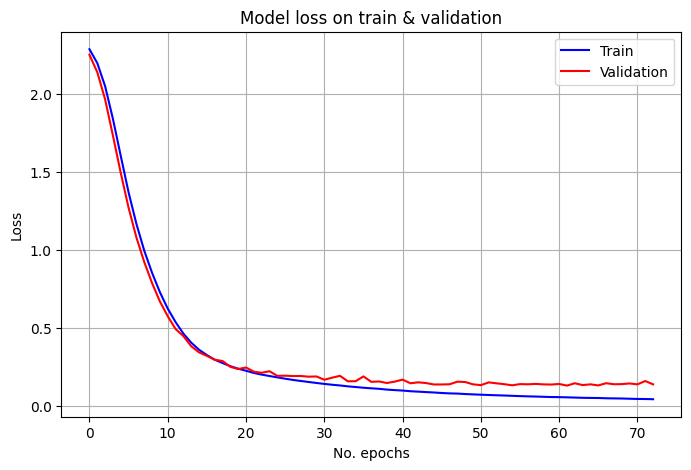

In [36]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

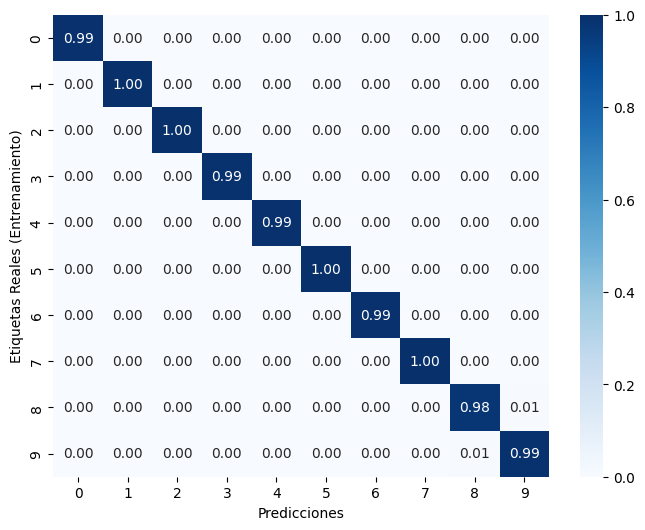

Accuracy Normalizado (Entrenamiento): 0.9934253780407627


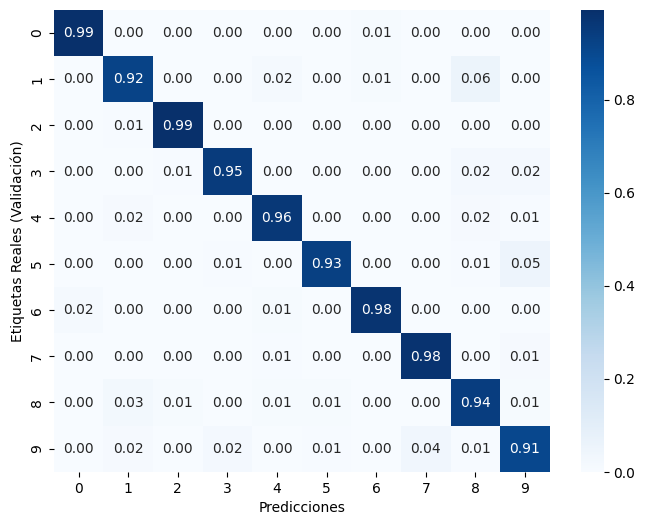

Accuracy Normalizado (Validación): 0.9555555555555556


In [37]:
# Guarda el modelo entrenado para el caso e
torch.save(model_e.state_dict(), 'model_e.pth')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score

# se calcula la matriz de confusión y el accuracy en el conjunto de entrenamiento
# Se crea la variable best_model para guardar el modelo en cuestión
best_model = model_e

# Se configura el modelo en modo de evaluación
best_model.eval()

# Se crean listas para almacenar predicciones y etiquetas reales
predictions_train = []
true_labels_train = []

# Se procede a evaluar el modelo en el conjunto de entrenamiento
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_train.extend(predicted.cpu().numpy())
        true_labels_train.extend(labels.cpu().numpy())

# Se calcula la matriz de confusión normalizada en el conjunto de entrenamiento, para luego crear un DataFrame de Pandas para la matriz de confusión en entrenamiento
confusion_matrix_train = confusion_matrix(true_labels_train, predictions_train, normalize='true')
confusion_df_train = pd.DataFrame(confusion_matrix_train, index=class_labels, columns=class_labels)

# Se configura el tamaño de la figura para entrenamiento
plt.figure(figsize=(8, 6))

# Se crea un heatmap de la matriz de confusión utilizando Seaborn para entrenamiento, para así visualizar la matriz de mejor manera
sns.heatmap(confusion_df_train, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Entrenamiento)")
plt.show()

# Se calcula el accuracy normalizado en entrenamiento
accuracy_normalized_train = accuracy_score(true_labels_train, predictions_train)
print("Accuracy Normalizado (Entrenamiento):", accuracy_normalized_train)

# para calcular con validación, se limpian las listas
predictions_train.clear()
true_labels_train.clear()

best_model.eval()

# Listas para almacenar predicciones y etiquetas reales en validación
predictions_val = []
true_labels_val = []

# Se evalúa el modelo en el conjunto de validación
with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_val.extend(predicted.cpu().numpy())
        true_labels_val.extend(labels.cpu().numpy())

# Aquí se define la matriz de confusión normalizada en el conjunto de validación y luego se crea un DataFrame de Pandas para la matriz de confusión en validación
confusion_matrix_val = confusion_matrix(true_labels_val, predictions_val, normalize='true')
confusion_df_val = pd.DataFrame(confusion_matrix_val, index=class_labels, columns=class_labels)

# se define el tamaño de la figura para validación
plt.figure(figsize=(8, 6))

# Se usa el comando seaborn heatmap para visualizar la matriz en cuestión
sns.heatmap(confusion_df_val, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Validación)")
plt.show()

# se calcula el accuracy normalizado en validación
accuracy_normalized_val = accuracy_score(true_labels_val, predictions_val)
print("Accuracy Normalizado (Validación):", accuracy_normalized_val)

In [38]:
# Configuración de la red para el caso 2f
model_f = nn.Sequential(
    nn.Linear(64, 40),  # Primera capa oculta con 40 neuronas
    nn.ReLU(),
    nn.Linear(40, 40),  # Segunda capa oculta con 40 neuronas
    nn.ReLU(),
    nn.Linear(40, 10)   # Capa de salida con 10 neuronas
)

model_f = model_f.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_f.parameters(), lr=1e-3)

# Definir parámetros de early stopping
patience = 10
best_val_loss = float('inf')
no_improvement_count = 0

In [39]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)


In [40]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []
best_val_loss = float('inf')
best_epoch = 0
# Entrenamiento de la red por n epocas
for epoch in range(1000):                  #Se definen épocas = 1000

  # Guardar loss de cada batch para cada parte de los datos
  loss_train_batches = []
  loss_val_batches = []


  # Entrenamiento --------------------------------------------------------------
  model_f.train() #se define para que empiece el entrenamiento
  # Se establece un for para recorrer cada batch en cada época y parte del conjunto de datos.
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    optimizer.zero_grad() #descenso del gradiente
    outputs = model_f(inputs)           # Predicciones de entrenamiento que obtuvo el modelo, se calcula la pérdida
    loss = criterion(outputs, labels) # Loss o pérdida de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Se guarda la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item()) #sacar número específico a la pérdida de un 1 solo batch

  # se guarda el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_f.eval() #se le pasan los datos de validación para medir que tan bueno es
  #es similar al código superior, pero con datos de variación en vez de entrenamiento, sacando así predicción, probando la red, en vez de entrenar.
  with torch.no_grad():
    # Se itera dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_f(inputs)              # Obtenemos predicciones

      # Se guarda la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Se guarda el Loss de validación de la época actual y la época
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Se define early stopping en base al loss de entrenamiento y validación
  if loss_val[-1] < best_val_loss:
        best_val_loss = loss_val[-1]
        best_epoch = epoch
  elif epoch - best_epoch > patience:  # Detener si el loss de validación no mejora en relación de la variable patience
        break
end = time.time()
print('Finished Training, total time %f seconds' % (end - start))


Epoch: 0, train loss: 2.2082, val loss: 2.0605
Epoch: 1, train loss: 1.8531, val loss: 1.5503
Epoch: 2, train loss: 1.2617, val loss: 0.9339
Epoch: 3, train loss: 0.6976, val loss: 0.4869
Epoch: 4, train loss: 0.3876, val loss: 0.3051
Epoch: 5, train loss: 0.2608, val loss: 0.2329
Epoch: 6, train loss: 0.1999, val loss: 0.1875
Epoch: 7, train loss: 0.1664, val loss: 0.1587
Epoch: 8, train loss: 0.1421, val loss: 0.1503
Epoch: 9, train loss: 0.1246, val loss: 0.1290
Epoch: 10, train loss: 0.1080, val loss: 0.1266
Epoch: 11, train loss: 0.0957, val loss: 0.1279
Epoch: 12, train loss: 0.0861, val loss: 0.1067
Epoch: 13, train loss: 0.0769, val loss: 0.1092
Epoch: 14, train loss: 0.0691, val loss: 0.1025
Epoch: 15, train loss: 0.0623, val loss: 0.1036
Epoch: 16, train loss: 0.0579, val loss: 0.0964
Epoch: 17, train loss: 0.0521, val loss: 0.0982
Epoch: 18, train loss: 0.0471, val loss: 0.1007
Epoch: 19, train loss: 0.0436, val loss: 0.0954
Epoch: 20, train loss: 0.0400, val loss: 0.0900
Ep

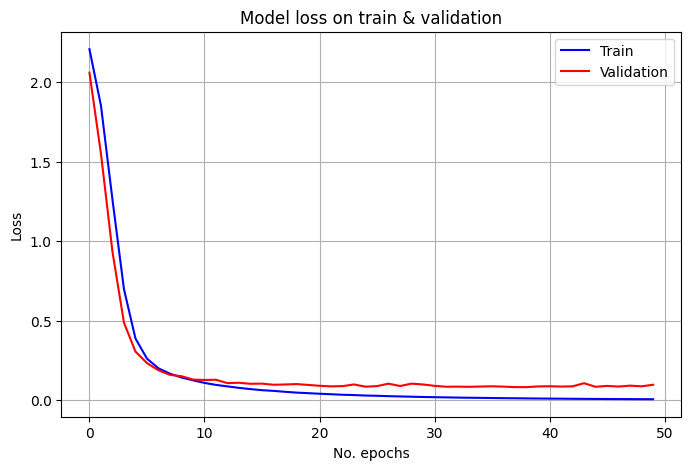

In [41]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()


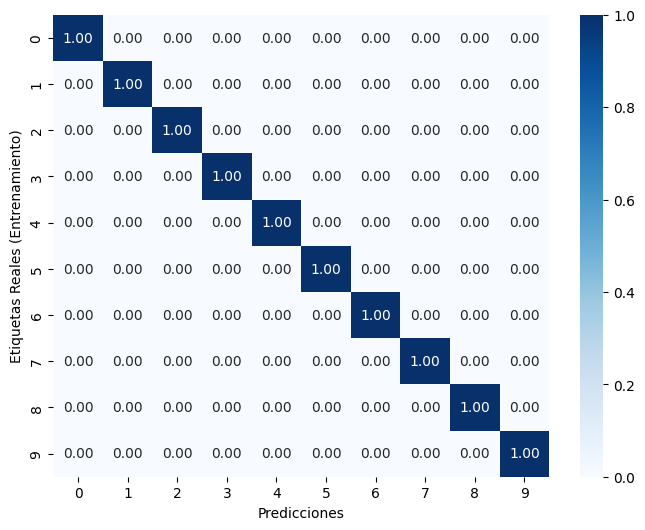

Accuracy Normalizado (Entrenamiento): 1.0


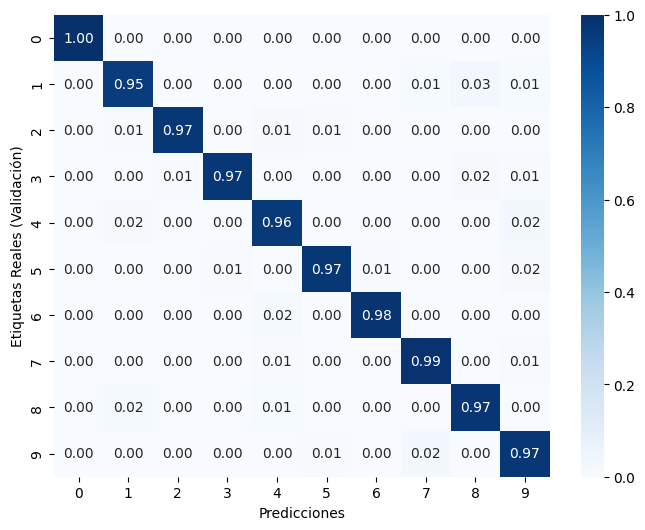

Accuracy Normalizado (Validación): 0.9739463601532568


In [42]:
# Guarda el modelo entrenado para el caso f
torch.save(model_f.state_dict(), 'model_f.pth')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score

# se calcula la matriz de confusión y el accuracy en el conjunto de entrenamiento
# Se crea la variable best_model para guardar el modelo en cuestión
best_model = model_f

# Se configura el modelo en modo de evaluación
best_model.eval()

# Se crean listas para almacenar predicciones y etiquetas reales
predictions_train = []
true_labels_train = []

# Se procede a evaluar el modelo en el conjunto de entrenamiento
with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_train.extend(predicted.cpu().numpy())
        true_labels_train.extend(labels.cpu().numpy())

# Se calcula la matriz de confusión normalizada en el conjunto de entrenamiento, para luego crear un DataFrame de Pandas para la matriz de confusión en entrenamiento
confusion_matrix_train = confusion_matrix(true_labels_train, predictions_train, normalize='true')
confusion_df_train = pd.DataFrame(confusion_matrix_train, index=class_labels, columns=class_labels)

# Se configura el tamaño de la figura para entrenamiento
plt.figure(figsize=(8, 6))

# Se crea un heatmap de la matriz de confusión utilizando Seaborn para entrenamiento, para así visualizar la matriz de mejor manera
sns.heatmap(confusion_df_train, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Entrenamiento)")
plt.show()

# Se calcula el accuracy normalizado en entrenamiento
accuracy_normalized_train = accuracy_score(true_labels_train, predictions_train)
print("Accuracy Normalizado (Entrenamiento):", accuracy_normalized_train)

# para calcular con validación, se limpian las listas
predictions_train.clear()
true_labels_train.clear()

best_model.eval()

# Listas para almacenar predicciones y etiquetas reales en validación
predictions_val = []
true_labels_val = []

# Se evalúa el modelo en el conjunto de validación
with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_val.extend(predicted.cpu().numpy())
        true_labels_val.extend(labels.cpu().numpy())

# Aquí se define la matriz de confusión normalizada en el conjunto de validación y luego se crea un DataFrame de Pandas para la matriz de confusión en validación
confusion_matrix_val = confusion_matrix(true_labels_val, predictions_val, normalize='true')
confusion_df_val = pd.DataFrame(confusion_matrix_val, index=class_labels, columns=class_labels)

# se define el tamaño de la figura para validación
plt.figure(figsize=(8, 6))

# Se usa el comando seaborn heatmap para visualizar la matriz en cuestión
sns.heatmap(confusion_df_val, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Se añaden etiquetas a los ejes
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales (Validación)")
plt.show()

# se calcula el accuracy normalizado en validación
accuracy_normalized_val = accuracy_score(true_labels_val, predictions_val)
print("Accuracy Normalizado (Validación):", accuracy_normalized_val)

----------------------------------------------------------------------------------------------------------------------------------------------------
Resultados para Modelo A:
Matriz de Confusión Normalizada (Entrenamiento):
Accuracy Normalizado (Entrenamiento): 0.9934253780407627


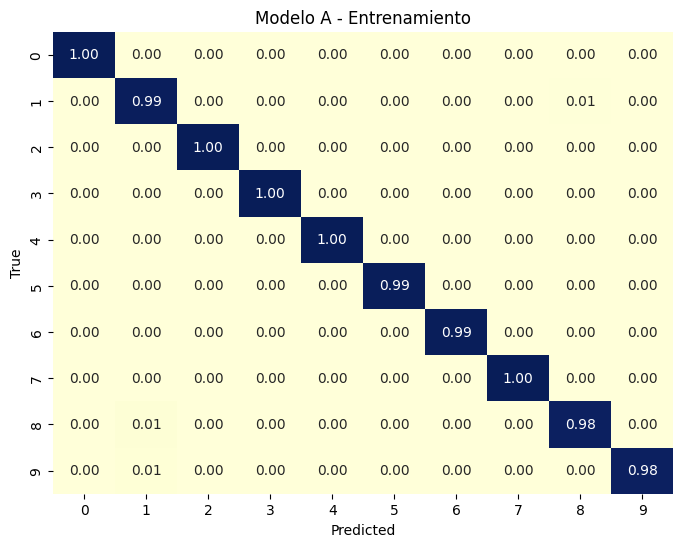

Matriz de Confusión Normalizada (Validación):
Accuracy Normalizado (Validación): 0.967816091954023


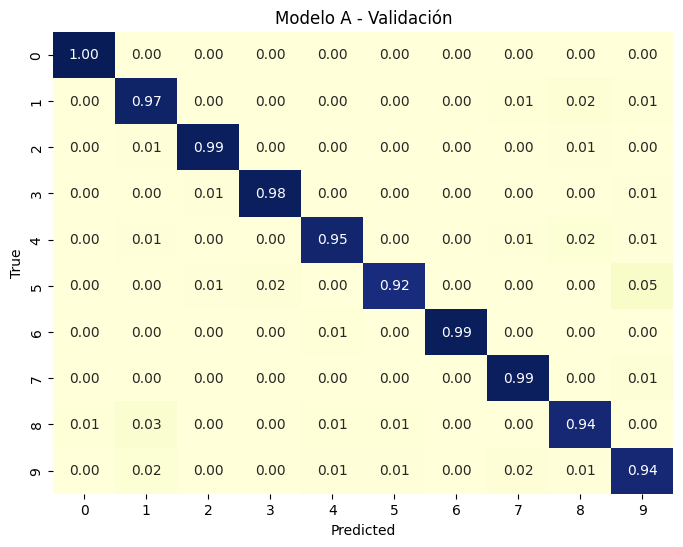

Matriz de Confusión Normalizada (Prueba):
Accuracy Normalizado (Prueba): 0.9685534591194969


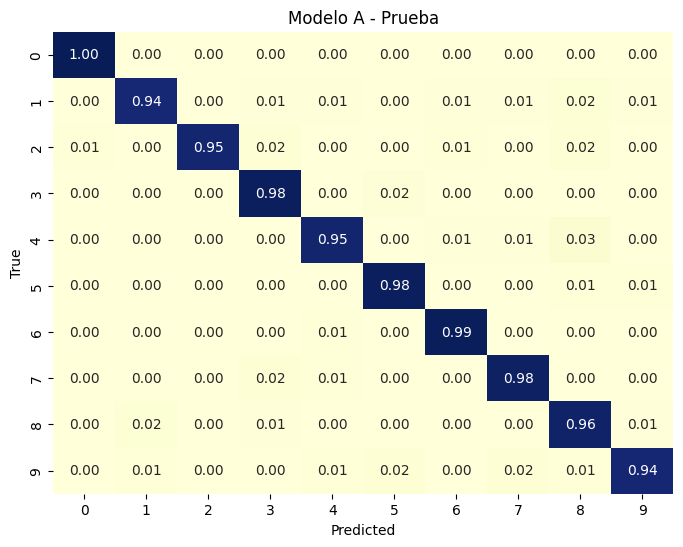

----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
Resultados para Modelo B:
Matriz de Confusión Normalizada (Entrenamiento):
Accuracy Normalizado (Entrenamiento): 0.9996712689020382


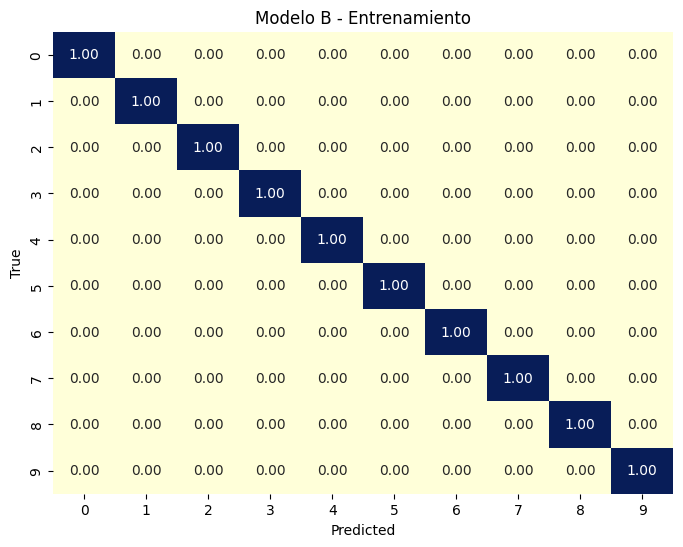

Matriz de Confusión Normalizada (Validación):
Accuracy Normalizado (Validación): 0.9762452107279693


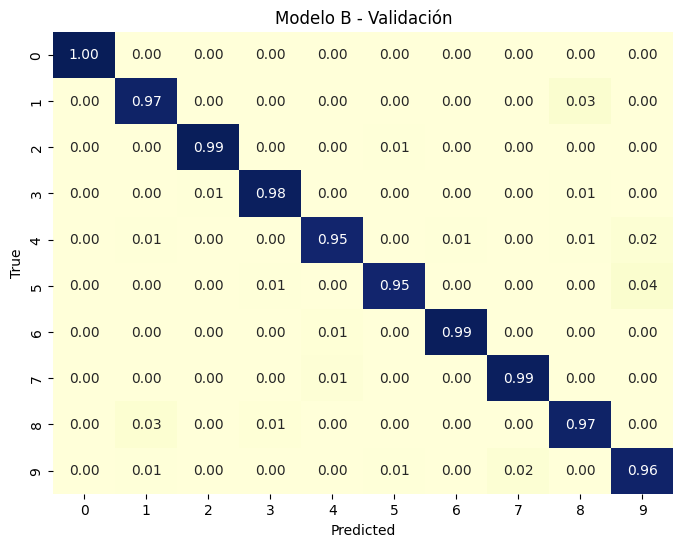

Matriz de Confusión Normalizada (Prueba):
Accuracy Normalizado (Prueba): 0.9819182389937107


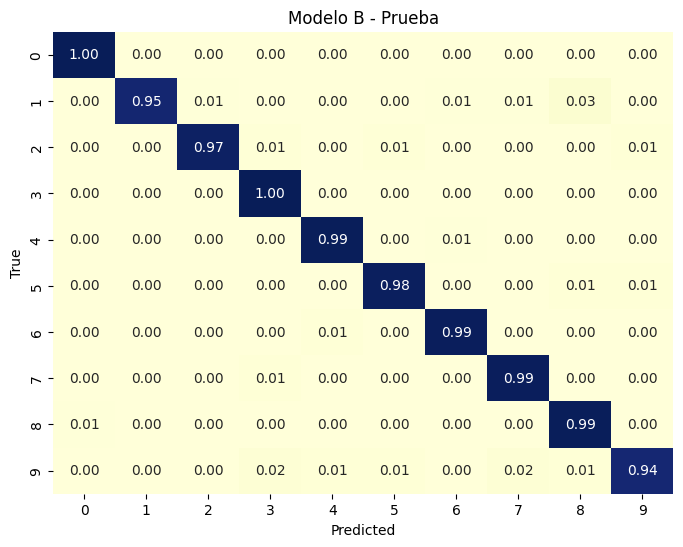

----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
Resultados para Modelo C:
Matriz de Confusión Normalizada (Entrenamiento):
Accuracy Normalizado (Entrenamiento): 0.9917817225509533


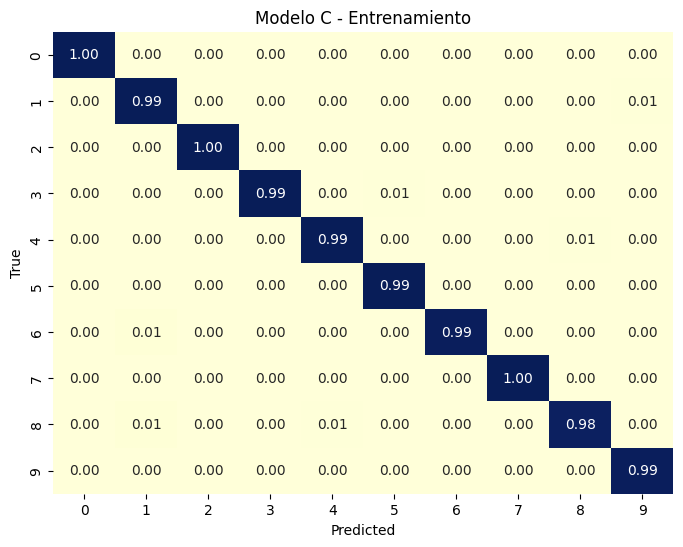

Matriz de Confusión Normalizada (Validación):
Accuracy Normalizado (Validación): 0.957088122605364


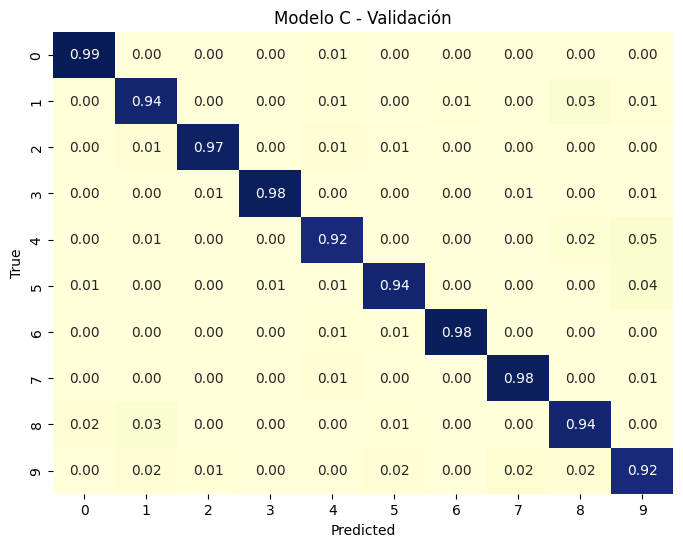

Matriz de Confusión Normalizada (Prueba):
Accuracy Normalizado (Prueba): 0.9591194968553459


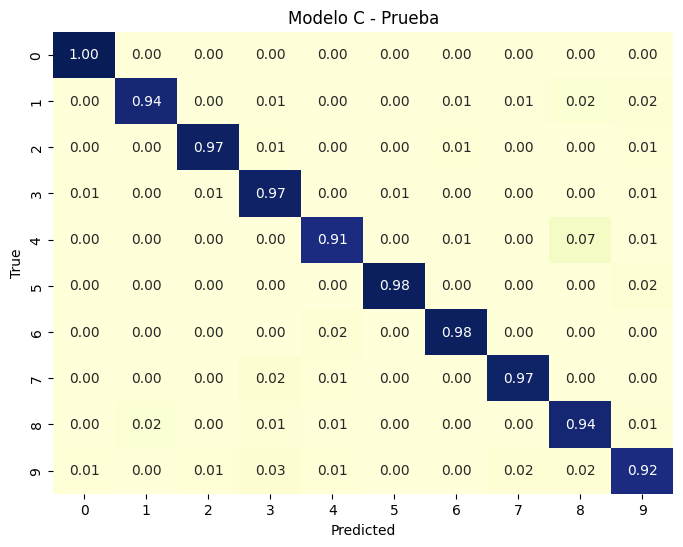

----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
Resultados para Modelo D:
Matriz de Confusión Normalizada (Entrenamiento):
Accuracy Normalizado (Entrenamiento): 0.9996712689020382


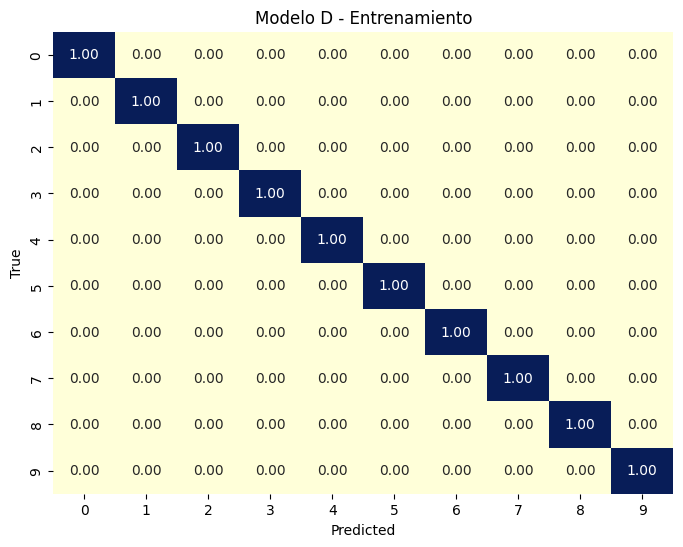

Matriz de Confusión Normalizada (Validación):
Accuracy Normalizado (Validación): 0.9762452107279693


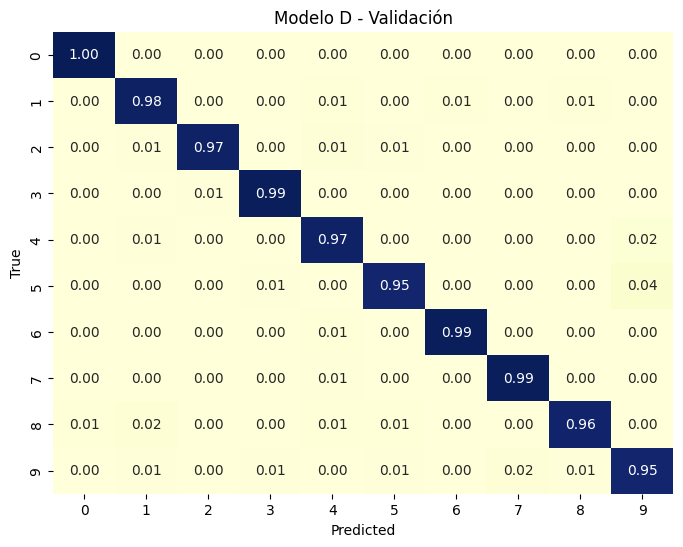

Matriz de Confusión Normalizada (Prueba):
Accuracy Normalizado (Prueba): 0.9772012578616353


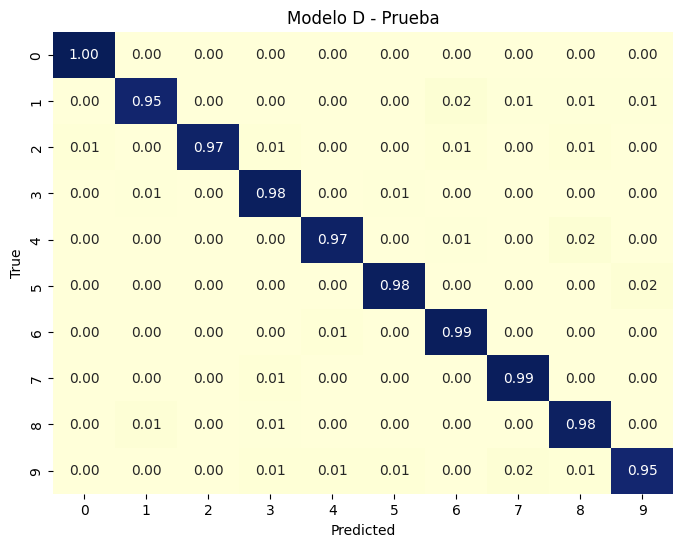

----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
Resultados para Modelo E:
Matriz de Confusión Normalizada (Entrenamiento):
Accuracy Normalizado (Entrenamiento): 0.9934253780407627


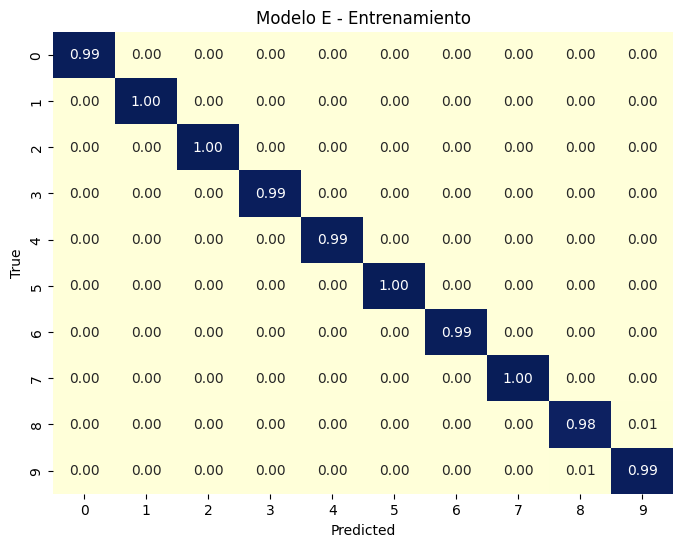

Matriz de Confusión Normalizada (Validación):
Accuracy Normalizado (Validación): 0.9555555555555556


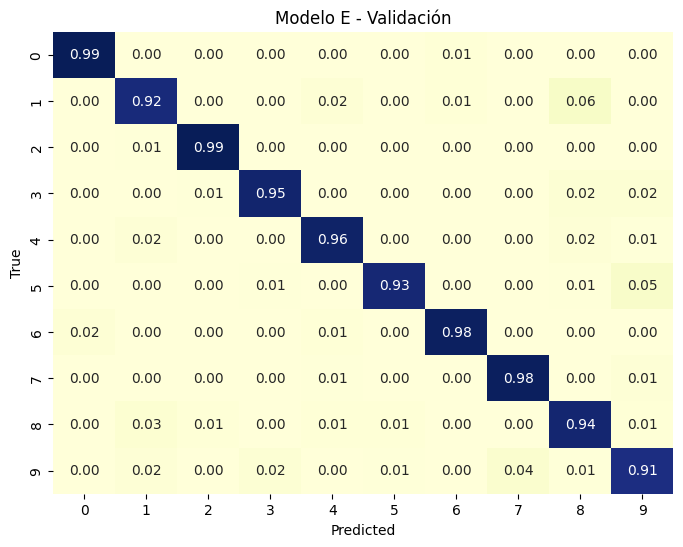

Matriz de Confusión Normalizada (Prueba):
Accuracy Normalizado (Prueba): 0.9567610062893082


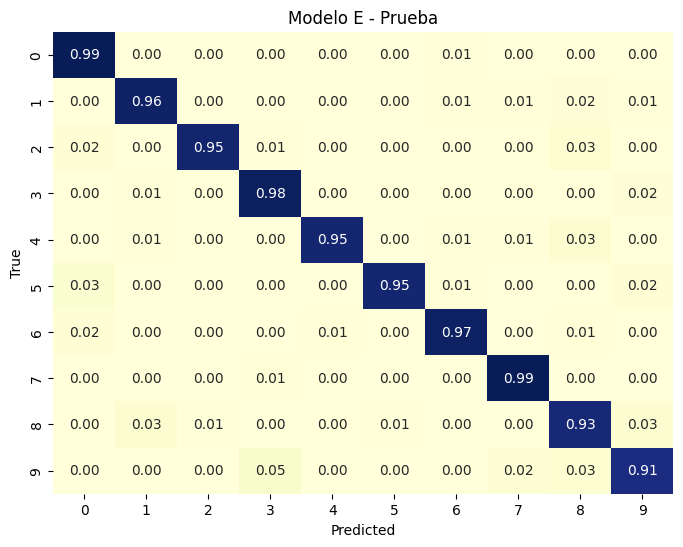

----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
Resultados para Modelo F:
Matriz de Confusión Normalizada (Entrenamiento):
Accuracy Normalizado (Entrenamiento): 1.0


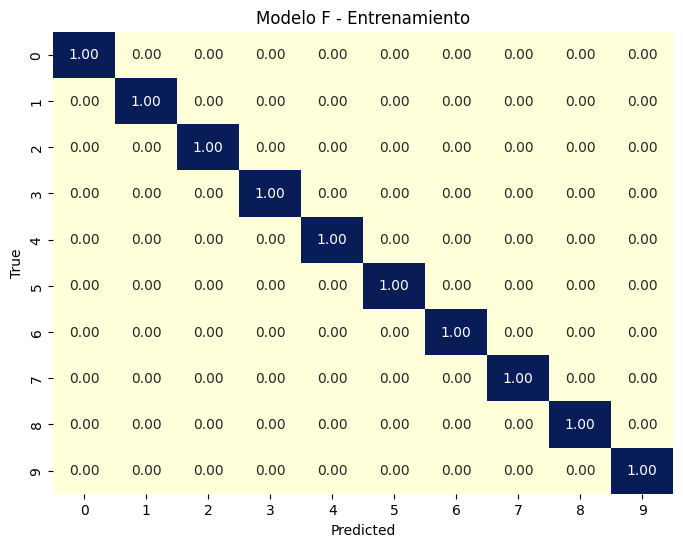

Matriz de Confusión Normalizada (Validación):
Accuracy Normalizado (Validación): 0.9739463601532568


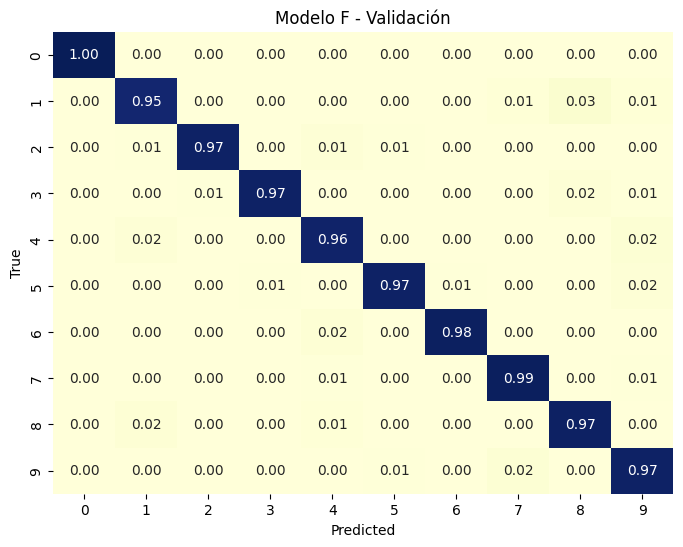

Matriz de Confusión Normalizada (Prueba):
Accuracy Normalizado (Prueba): 0.9772012578616353


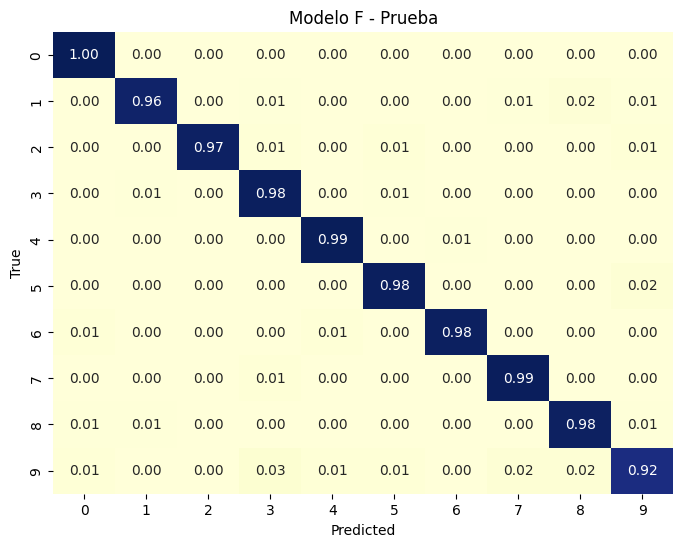

----------------------------------------------------------------------------------------------------------------------------------------------------
El mejor modelo encontrado en validación es Modelo B con un accuracy de validación de 0.9762
Mejores modelos en el conjunto de entrenamiento:
Modelo Modelo F con un accuracy en entrenamiento de 1.0000

Mejores modelos en el conjunto de validación:
Modelo Modelo B con un accuracy en validación de 0.9762
Modelo Modelo D con un accuracy en validación de 0.9762

Mejores modelos en el conjunto de prueba:
Modelo Modelo B con un accuracy en prueba de 0.9819


In [43]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score


def evaluar_modelo(modelo, dataloader):
    modelo.eval()

    # Listas para almacenar predicciones y etiquetas reales
    predictions = []
    true_labels = []

    # Se evalua el modelo en el conjunto de prueba
    with torch.no_grad():
        for data in dataloader:
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # se calcula la matriz de confusión normalizada y su accuracy normalizado
    confusion_matrix_normalized = confusion_matrix(true_labels, predictions, normalize='true')
    accuracy_normalized = accuracy_score(true_labels, predictions)

    return confusion_matrix_normalized, accuracy_normalized

#Se crea una función para visualizar las matrices en base a los 3 conjuntos
def plot_confusion_matrix(confusion_matrix, class_labels, title):
    # se convierte la matriz de confusión en un DataFrame de pandas
    confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

    # Se configuran los datos y medidas para la matriz
    plt.figure(figsize=(8, 6))
    # Se crea matriz con seaborn para mejor visualización
    sns.heatmap(confusion_df, annot=True, cmap="YlGnBu", fmt='.2f', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

#Se crea una lista de modelos y para matrices de confusión y accuracies
modelos = [model_a, model_b, model_c, model_d, model_e, model_f]
model_labels = ["Modelo A", "Modelo B", "Modelo C", "Modelo D", "Modelo E", "Modelo F"]
confusion_matrices_train = []
accuracies_train = []
confusion_matrices_val = []
accuracies_val = []
confusion_matrices_test = []
accuracies_test = []

for modelo in modelos:
    # Se evalua en el conjunto de entrenamiento, validación y prueba
    confusion_matrix_train, accuracy_train = evaluar_modelo(modelo, dataloader_train)
    confusion_matrices_train.append(confusion_matrix_train)
    accuracies_train.append(accuracy_train)

    confusion_matrix_val, accuracy_val = evaluar_modelo(modelo, dataloader_val)
    confusion_matrices_val.append(confusion_matrix_val)
    accuracies_val.append(accuracy_val)

    confusion_matrix_test, accuracy_test = evaluar_modelo(modelo, dataloader_test)
    confusion_matrices_test.append(confusion_matrix_test)
    accuracies_test.append(accuracy_test)

for i, modelo in enumerate(model_labels):
    print("----------------------------------------------------------------------------------------------------------------------------------------------------")
    print(f"Resultados para {modelo}:")

    # Matriz y accuracy de entrenamiento, validación y prueba
    print("Matriz de Confusión Normalizada (Entrenamiento):")
    print(f"Accuracy Normalizado (Entrenamiento): {accuracies_train[i]}")
    plot_confusion_matrix(confusion_matrices_train[i], class_labels, f"{modelo} - Entrenamiento")
    print("Matriz de Confusión Normalizada (Validación):")
    print(f"Accuracy Normalizado (Validación): {accuracies_val[i]}")
    plot_confusion_matrix(confusion_matrices_val[i], class_labels, f"{modelo} - Validación")
    print("Matriz de Confusión Normalizada (Prueba):")
    print(f"Accuracy Normalizado (Prueba): {accuracies_test[i]}")
    plot_confusion_matrix(confusion_matrices_test[i], class_labels, f"{modelo} - Prueba")
    print("----------------------------------------------------------------------------------------------------------------------------------------------------")


#Se define el modelo con el mayor accuracy de validación
best_model_idx = np.argmax(accuracies_val)
best_model = modelos[best_model_idx]
best_model_label = model_labels[best_model_idx]

print(f"El mejor modelo encontrado en validación es {best_model_label} con un accuracy de validación de {accuracies_val[best_model_idx]:.4f}")


# Se crea una lista de modelos y para matrices de confusión y accuracies
modelos = [model_a, model_b, model_c, model_d, model_e, model_f]
model_labels = ["Modelo A", "Modelo B", "Modelo C", "Modelo D", "Modelo E", "Modelo F"]
confusion_matrices_train = []
accuracies_train = []
confusion_matrices_val = []
accuracies_val = []
confusion_matrices_test = []
accuracies_test = []

# Se crean listas para el mejor modelo y su accuracy en cada conjunto
best_models_train = []
best_accuracies_train = []
best_models_val = []
best_accuracies_val = []
best_models_test = []
best_accuracies_test = []

for modelo in modelos:
    # Se evalua en el conjunto de entrenamiento, validación y prueba
    confusion_matrix_train, accuracy_train = evaluar_modelo(modelo, dataloader_train)
    confusion_matrices_train.append(confusion_matrix_train)
    accuracies_train.append(accuracy_train)

    confusion_matrix_val, accuracy_val = evaluar_modelo(modelo, dataloader_val)
    confusion_matrices_val.append(confusion_matrix_val)
    accuracies_val.append(accuracy_val)

    confusion_matrix_test, accuracy_test = evaluar_modelo(modelo, dataloader_test)
    confusion_matrices_test.append(confusion_matrix_test)
    accuracies_test.append(accuracy_test)

# Se almacena el mejor modelo y su accuracy en cada conjunto
for i, modelo in enumerate(model_labels):
    # Para el conjunto de entrenamiento
    if len(best_accuracies_train) == 0 or accuracies_train[i] > max(best_accuracies_train):
        best_models_train = [modelo]
        best_accuracies_train = [accuracies_train[i]]
    elif accuracies_train[i] == max(best_accuracies_train):
        best_models_train.append(modelo)
        best_accuracies_train.append(accuracies_train[i])

    # Para el conjunto de validación
    if len(best_accuracies_val) == 0 or accuracies_val[i] > max(best_accuracies_val):
        best_models_val = [modelo]
        best_accuracies_val = [accuracies_val[i]]
    elif accuracies_val[i] == max(best_accuracies_val):
        best_models_val.append(modelo)
        best_accuracies_val.append(accuracies_val[i])

    # Para el conjunto de prueba
    if len(best_accuracies_test) == 0 or accuracies_test[i] > max(best_accuracies_test):
        best_models_test = [modelo]
        best_accuracies_test = [accuracies_test[i]]
    elif accuracies_test[i] == max(best_accuracies_test):
        best_models_test.append(modelo)
        best_accuracies_test.append(accuracies_test[i])

# Se imprime o utiliza los resultados
print("Mejores modelos en el conjunto de entrenamiento:")
for i, modelo in enumerate(best_models_train):
    print(f"Modelo {modelo} con un accuracy en entrenamiento de {best_accuracies_train[i]:.4f}")

print("\nMejores modelos en el conjunto de validación:")
for i, modelo in enumerate(best_models_val):
    print(f"Modelo {modelo} con un accuracy en validación de {best_accuracies_val[i]:.4f}")

print("\nMejores modelos en el conjunto de prueba:")
for i, modelo in enumerate(best_models_test):
    print(f"Modelo {modelo} con un accuracy en prueba de {best_accuracies_test[i]:.4f}")
